# Texture synthesis using deep convolutional networks

This numerical tour implements the method detailed in the paper of [Gatys et al.](https://arxiv.org/pdf/1505.07376.pdf). The implementation is intended to be as simple as possible, using Pytorch hooks to be applicable to any network (as opposed to the [style transfer implementation](https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb)).

This tour can be used as a gentle introduction to convolutional networks, where one can use a pre-trained network to perform a non-trivial vision task (involving in particular an optimization using back-propagation through the network). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

Uncomment if you want to store to your own google drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Check if CUDA is available.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Image loading and normalization

Load the image $f \in \mathbb{R}^{3 \times n_0 \times n_0}$ where $3$ is the number of input channels.

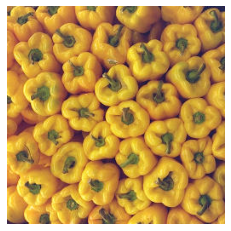

In [4]:
from urllib.request import urlopen
import io
file_adress = 'https://raw.githubusercontent.com/leongatys/DeepTextures/master/Images/pebbles.jpg'
file_adress = 'http://graphics.stanford.edu/projects/texture/demo/texture_data/original/eero/radishes256.o.jpg'
file_adress = 'http://graphics.stanford.edu/projects/texture/demo/texture_data/original/eero/olives256.o.jpg'
file_adress = 'http://graphics.stanford.edu/projects/texture/demo/texture_data/original/eero/tomatoes256.o.jpg'
file_adress = 'http://graphics.stanford.edu/projects/texture/demo/texture_data/original/eero/yellow-peppers256.o.jpg'
fd = urlopen(file_adress)
image_file = io.BytesIO(fd.read())
f_pil = Image.open(image_file)
plt.imshow(f_pil)
plt.axis('off');

Image normalization (to fit network normalization during training)
$$ \forall \ell \in \{0,1,2\}, \quad f[\ell,\cdot,\cdot] \leftarrow (f[\ell,\cdot,\cdot]-m_\ell)/\sigma_\ell $$
where $m$ and $\sigma$ are the empirical mean and standard deviation of the training set (here [imagenet](http://www.image-net.org/) dataset).

In [5]:
n = 256
def normalize(f):
    preprocess = transforms.Compose([
    transforms.Resize(n),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return torch.autograd.Variable(preprocess(f).unsqueeze(0).cuda())
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

## Neural network loading and testing.

Load a pre-trained (on imagenet) neural network architecture.

In [6]:
nn_type = 'resnet'
nn_type = 'vgg'
if nn_type=='vgg':
  cnn = models.vgg19(pretrained=True)
elif nn_type=='resnet':
  cnn = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# no need to store the gradient
for param in cnn.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    cnn.cuda()

Starting from $f_0 = f \in \mathbb{R}^{m_0=3 \times n_0 \times n_0}$ the input image, the "feature" part of the newtork alternates layers of the form
$$
  f_{i+1} \equiv \Psi_i(f_i) 
  \equiv [ \text{ReLu}( f_{i} \star w_i) ]_{\downarrow s_i}
  = \Psi_i \circ \Psi_{i-1} \circ \ldots \circ \Psi_0(f_0).
$$
Here $f_{i} \in \mathbb{R}^{m_i \times n_i \times n_i}$ has $m_i$ channels and $n_i^2$ pixels (we assume square images for simplicity), $\star w_i[\ell,\ell',\cdot,\cdot]$ are the convolution filters, so that 
$$
    \forall 0 \leq \ell < m_{i+1}, \quad
    ( f_{i} \star w_i )[ \ell,x,y ] = \sum_{\ell',x',,y'}
      w_i[\ell,\ell',x-x',y-y'] f_{i}[\ell',x',y'].
$$
ReLu is the Rectified Liner Unit non-linearity ReLu$(s)=\max(s,0)$ and is implicitly applied to each element of a tensor.

The operation $[\cdot]_{\downarrow s_i}$ is a downsampling by a factor $s_i \in \{0,2\}$. If $s_i=0$, nothing is done (so that $n_{i+1}=n_i$), but if $s_i=2$, then the number of pixels is reduced by a factor $4$ and $n_{i+1}=n_i/2$. 
The most usual sub-sampling operator (when $s_i=2$) is the max-pooling, where 
$$
  (A_{\downarrow 2})[\ell,x,y] \equiv \max(A[\ell,2x,2y],A[\ell,2x+1,2y],A[\ell,2x,2y+2],A[\ell,2x+1,2y+1]).
$$

In the following, we denote
$$
  \Phi_i(f_0) \equiv f_i
  \quad \text{i.e.} \quad
  \Phi_i \equiv \Psi_{i-1} \circ \ldots \circ \Psi_0, 
$$
the map from the input image $f_0$ to the output of the ith layer of the network.

Note that for image classification tasks, this "feature" part is followed by a "classiciation" part, which is composed of a few fully connected (i.e. non-convolutive) layers and a final soft-max layer to output a probability vector among the classes of the dataset. During the training phase, a muli-class classification loss is minized by stochastic gradient descent to tune the convolution filters $(w_i)_i$. This part is assumed to already be done, and we do not optimize the weights $(w_i)_i$ in this tour. 

We can display the architecture of the network, which has 16 feature layers, with only 5 having $s_i=2$ (pooling). This means that the final size of the image feature are $n_{16}=n_0/2^5$. The number of channel grows like $m_0=3,64, 128, 256, m_{16}=512$. 

In [7]:
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Function to save activations when applying a network.

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output #.detach()
    return hook

Create a function to evaluate the network and retrieve a list $I$ of activations of some layers $(\Phi_i(f))_{i \in I}$.

In [9]:
# sub-select only a sub-set of output
if nn_type=='vgg':
  I = range(0,37) # all the layers
  I = [0] # first layer only
  I = [36] # last layer only
  I = [0, 4, 9, 18, 27] # first and after pooling
  it = 0
  for i in I:
    cnn.features[i].register_forward_hook(get_activation(it))
    it = it+1
elif nn_type=='resnet':
  it = 0
  cnn.conv1.register_forward_hook(get_activation(it)); it = it+1
  cnn.layer1[2].register_forward_hook(get_activation(it)); it = it+1
  cnn.layer2[3].register_forward_hook(get_activation(it)); it = it+1
  cnn.layer3[5].register_forward_hook(get_activation(it)); it = it+1
  cnn.layer4[2].register_forward_hook(get_activation(it)); it = it+1

In [10]:
if nn_type=='vgg':
  for i in I:
    print( cnn.features[i] )

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Apply the network, this will save the activations in the variable `activation`.


In [11]:
f = normalize(f_pil)
cnn(f);

In [12]:
for a in activation:
  print(activation[a].shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])


Display the first channel of each saved activations, i.e. $(f_i[0,\cdot,\cdot])_{i \in I}$.

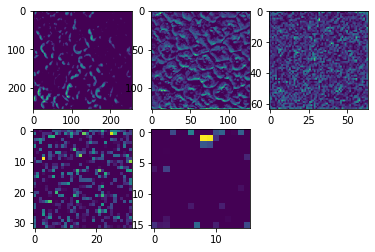

In [13]:
for a in activation:
  plt.subplot(2,3,a+1)
  plt.imshow(activation[a].cpu()[0,0,:,:].squeeze())

Now display the total activation over the channels by summation, i.e. $(\sum_\ell f_i[\ell,\cdot,\cdot])_{i \in I}$.

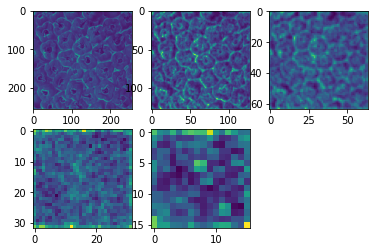

In [14]:
for a in activation:
  plt.subplot(2,3,a+1)
  plt.imshow(torch.sum(activation[a].cpu(), axis=1).squeeze())

## Texture synthesis through optimization

The general idea of statistical texture synthesis (as opposed to "copy-based" methods) is to draw a random noise image and then coerce it to enforce some empirical statistics to match those of the input one. 

The initial idea appears in the early work of [Heeger and Bergen](https://www.cns.nyu.edu/heegerlab/content/publications/Heeger-siggraph95.pdf) which simply uses the histograms over a wavelet transform. This was refined by [Zhu and Mumford](https://link.springer.com/article/10.1023/A:1007925832420), and by [Portilla and Simoncelli](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf), which uses more complex statistical descriptors (in particular higher order moments). The idea of Gatys' method is similar excepted it replaces the linear wavelet transform by a non-linear neural network. 

In this neural network texture model, one only makes use of second order morment. 

We denote $C(h) \in \mathbb{R}^{m \times m}$ the empirical covariance of a feature image $h \in \mathbb{R} ^{m \times n \times n}$ defined as
$$
  \forall 0 \leq \ell,\ell'<m, \quad
   C(h)[\ell,\ell'] \equiv \frac{1}{n^2} \sum_{x,y} h[\ell,x,y] h[\ell',x,y] .
$$

In [15]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w) # normalize by the number of samples
        return G

Compute the list of all Gram matrices (important: use `detach` to return a new tensor) $( G(\Phi_i(f)) )_{i \in I}$.



In [16]:
f_gram = [GramMatrix()(activation[a]).detach() for a in activation]

Display those gram matrices (the log of their absolute values).

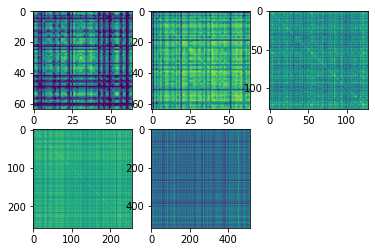

In [17]:
for a in activation:
  plt.subplot(2,3,a+1)
  U = f_gram[a].cpu().squeeze()
  plt.imshow(  torch.log(.01 + torch.abs(U)) )

The texture synthesis energy is defined as the sum of the squared Euclidean distance between the covariances of the texture $g$ to synthesize and those of the input exemplar $f$:
$$
  \mathcal{E}(g) \equiv \sum_{i \in I} \lambda_i \| C(\Phi_i(f)) - C(\Phi_i(g)) \|_2^2
$$

The normalization weights $(\lambda_i)_{i \in I}$ here are chosen as the the size of the Gram matrix, $\lambda_i=c/m_i^2$, for some constant $c$ (which role is not very clear, but apparently the L-BFGS of Pytorch is quite sensitive to normalization of the gradient). Other choices are possible to improve the results.

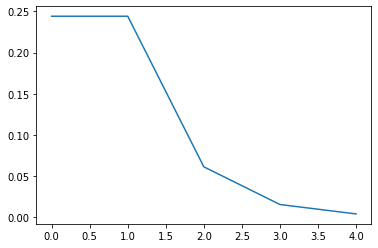

In [18]:
weights = [1e3/f_gram[i].shape[1]**2 for i in range(0,len(f_gram))]
plt.plot(weights);

The initial input texture satisfies $\mathcal{E}(f)=0$ so it is a (probably unique?) global minimizer of $\mathcal{E}$. The goal of this type of variational texture synthesis method is somehow to sample randomly local minimizers of this energy. This is the general ideal underlying so-called "energy-based models".

We thus start using some random initialization.

In [19]:
m = n # synthesis size, can be different from the input image size
g = torch.autograd.Variable(torch.rand([1,3,m,m]).type_as(f.data), requires_grad=True)

Compute and display the covariances $\{ C(\Phi_i(g)) \}_{i \in I}$ at initialization.

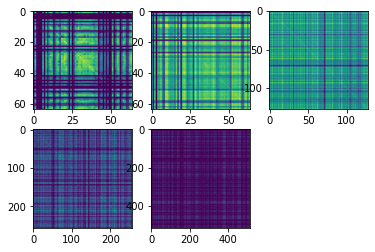

In [20]:
optimizer = optim.LBFGS([g]);
optimizer.zero_grad()
tmp = cnn(g)
g_gram = [GramMatrix()(activation[a]) for a in activation]
for a in activation:
  plt.subplot(2,3,a+1)
  U = g_gram[a].detach().cpu().squeeze()
  plt.imshow(  torch.log(.01 + torch.abs(U)) )

We can now evaluate the loss function $\mathcal{E}(g)$ associated to the current texture image $g$.


In [21]:
layer_losses = [weights[a] * nn.MSELoss()(g_gram[a], f_gram[a]) for a in activation]
loss = sum(layer_losses)

The synthesis method proceeds by some gradient-based optimization method.  
The main technical difficulty here is thus to compute the gradient of the energy $\mathcal{E}$. Fortunatly, this can be done automatically using Pytorch automatic differentiation features. It corresponds to the use of the so-called reverse mode automatic differentiation, which back-propagates the gradient of the loss function through the computational graph. 

For the sake of simplicity, let's consider only the covariance at a single depth 
$$\mathcal{E}(g) = \frac{1}{2} \| C(\Phi_i(g)) - C_i \|_2^2$$ 
where $C_i \equiv C(\Phi_i(f))$ is fixed (the general cases being obtained by a sum over $i \in I$).

The chain rule for the gradient then reads 
$$
  \nabla \mathcal{E}(g) = 
  [\partial \Phi_i(g)]^\top \times 
  [\partial C(g_i)]^\top \times 
   ( C(\Phi_i(g)) - C_i )
$$
where we denoted $g_i \equiv \Phi_i(g)$ the activation of the network.
Here, denoting $\Phi_i : \mathbb{R}^{d} \rightarrow \mathbb{R}^{d_i}$ (where $d=3n^2$ and $d_i=m_i n_i^2$ are the dimension of the feature maps), $\partial \Phi_i(g) \in \mathbb{R}^{d_i \times d}$ is the Jacobian and $[\partial \Phi_i(g)]^\top \in \mathbb{R}^{d \times d_i}$ is its adjoint (in term of matrix: its transpose).

Using the fact that $\Phi_i = \Psi_i \circ \ldots \Psi_0$, one has 
$$
  \nabla \mathcal{E}(g) = 
  [\partial \Psi_0(g_0)]^\top \times \ldots \times
  [\partial \Psi_{i-2}(g_{i-1})]^\top \times  
  [\partial \Psi_{i-1}(g_{i-1})]^\top \times  
  [\partial C(g_i)]^\top \times
  ( C(\Phi_i(g)) - C_i )
$$
The fundamental ideal of back-propgation is to evaluate this formula from right to left, in order to minimize the number of computations, since this boilds down to applying linear operators (adjoints of the Jacobians) to vectors.

Recal that here, $\Psi_i(h) = [ \text{ReLu}( h \star w_i) ]_{\downarrow s_i}$, so that 
$$
  [\partial \Psi_i(h)]^\top : e \mapsto 
  ( \text{sign}(h \star w_i) \odot e_{\uparrow s_i} ) \star \bar w_i
$$
where $\bar w_i[\ell,x,y] \equiv w_i[\ell,-x,-y]$ is the reversed filter (for the sake of simplicity, we assume periodic boundary condition, otherwise the boundary condition needs to be taken into account when computing the transposed of the convolution operator). The operator 
$$
  (u \odot v)[\ell,x,y] = u[\ell,x,y] v[\ell,x,y] 
$$ 
is the pointwise multiplication of vector (Hadamard product). When $s_i=0$, then $e_{\uparrow 0}=e$ is the identity, and when $s_i=2$, $f = e_{\uparrow 2}$ is a (non-linear) upsampling operator (douling the dimension by inserting zeros according to the localization of the maximum in the max pooling).

Note that to apply this method, all the activations $g_i$ should be kept in memory, so that the method is memory intensive. 

We can apply Pytorch auto-grad feature to perform all this computation.

In [22]:
loss.backward()

We can display the gradient $\nabla \mathcal{E}(g) \in \mathbb{R}^{3 \times n \times n}$ as a color image.

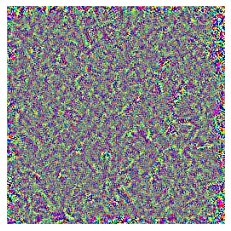

In [23]:
U = g.grad.detach().cpu().squeeze().permute(1,2,0)
U = U/torch.max(torch.abs(U))
U = torch.clip(U,-.1,.1)*5+.5
plt.imshow(U)
plt.axis('off');

We use here a quasi-Newton method, of the form
$$ g \mapsto g - H(g)^{-1} \nabla \mathcal{E}(g) $$
where  $H(g)^{-1}$ is intended to approximate the inverse of the Hessian of $\mathcal{E}$ at $g$, and is computed here by using the memory limite version of a BFGS quasi-Newton, which is often believed to be the most efficient method for smooth optimization when one can compute exactly the gradient and the number of parameters is not too large (so that this cannot be used to train the weights $w_i$ of the network, and stochastic gradient methods are prefered)

In [24]:
optimizer = optim.LBFGS([g]);
niter = 100 # ~300 iterations recommended
L = []
g_svg = []
for it in range(0,niter):
  def closure():
    # reset the gradient
    optimizer.zero_grad()
    # apply the network
    cnn(g);
    # compute gram matices of the activations
    g_gram = [GramMatrix()(activation[a]) for a in activation]
    # compute the loss function
    layer_losses = [weights[a] * nn.MSELoss()(g_gram[a], f_gram[a]) for a in activation]
    loss = sum(layer_losses)
    # perfor the backpropagation to obtain the gradient
    loss.backward()
    L.append(loss.item())
    return loss
  g_svg.append(g.clone().detach())
  optimizer.step(closure)

Display the evolution of the loss $\mathcal{E}$, in log domain.

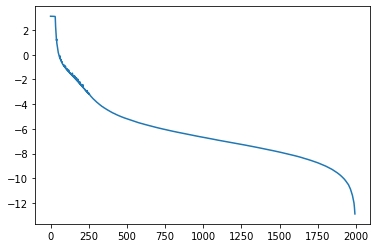

In [25]:
plt.plot(np.log(L[:-5]-np.min(L)));

Display the final synthesized image $g$.

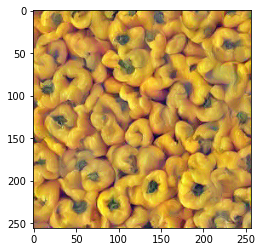

In [26]:
def retrieve_img(g):
  u = g.permute(2, 3, 1, 0).squeeze()
  u = deprocess(u).detach().cpu()
  u = np.clip(u,0,1) # enforce pixel value in [0,1]
  return u
plt.imshow(retrieve_img(g));

Export the progress of optimization as a video.

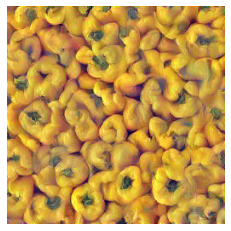

In [27]:
import matplotlib.animation as animation
ims = []
fig = plt.figure()
for i in range(niter):
    plt.axis('off')
    im = plt.imshow(retrieve_img(g_svg[i]))  
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)
ani.save('synthesis.mp4')

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>